* [1. IMPORTING LIBRARIES](#1)
* [2. LOADING DATA](#2)
* [3. DATA PREPREPROCESSING](#3)
* [4. Data Visualization](#4)
* [5. Splitting dataset](#5)
* [6. VECTORIZATION](#6)
* [7. MODEL BUILDING](#7)
* [8. Model Evaluation](#8)
* [9. Data Pipeline](#9)

# IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import email
import string
from string import punctuation
from bs4 import BeautifulSoup

import re
import nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

#from stop_words import get_stop_words
import os

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix , f1_score , accuracy_score , precision_recall_curve , roc_auc_score , roc_curve

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline


from sklearn.model_selection import cross_val_predict

from gensim.models import word2vec

import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
np.random.seed(49)

# LOADING DATA

In [2]:
easy_ham_path = 'easy_ham/'
hard_ham_path = 'hard_ham/'
spam_path = 'spam_2/'

In [3]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

- on recupere les donnees

In [4]:
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)





In [5]:
print(len(ham))
print(len(spam))

2801
1397


In [ ]:
#print(spam[49]) # take a look to the structure of our data


# DATA PREPREPROCESSING

In [6]:

#les Non-Mots
nltk_stopwords = set(stopwords.words("english"))
sklearn_stopwords = set(ENGLISH_STOP_WORDS)

list_of_stop_words = list(nltk_stopwords.union(sklearn_stopwords)) + ["<",">"]



nlp = English()#modele de nlp en anglais,on va l'utiliser pour la tokenization

stemmer = PorterStemmer() #stemming

lemmatizer = WordNetLemmatizer()#lemmatization

#regex pour les tags html
# html_supp=re.compile("<.*\n*.+>")
html_supp=re.compile(r"<\/?.+?\n*.+>")

#regex pour les URL
url_sub=re.compile(r"https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)")

#regex pour les Emails
email_sub=re.compile(r"[\w\-.]+@[\w\-.]+(\.\w{2,3})")
# email_sub=re.compile(r"\w+([\.-]?\w+)*@\w+([\.-]?\w+)*(\.\w{2,3})+")

#regex pour les nombres
#num_sub=re.compile(r"\b[0-9]+([.,:\s]+[0-9]+)*\b")
#num_sub=re.compile(r"\b[0-9]+\b")
num_sub=re.compile(r"[0-9]+")

#regex pour $
dollar_sub=re.compile(r"(\$)+")

#regex pour les espaces
space_sub=re.compile(r"\s+")



In [8]:
def clean_emails(email):

        # miniscule
        email = email.lower()
        
        #html supp
        email = re.sub(html_supp,"",email)
        
        #email adresse replace
        email = re.sub(email_sub,"emailaddr",email)
        
        # #url replace
        
        email = re.sub(url_sub,"httpaddr",email)
    
      
        # #numbers replace
        
        email = re.sub(num_sub,"nombre",email)
       
        # #dollar sign replace
        
        email = re.sub(dollar_sub,"dollar",email)
        
        # #whitespaces  replace
        email = re.sub(space_sub," ",email)

        
        #tokenization
        
        tokens = [lemmatizer.lemmatize(stemmer.stem(token.text))  for token in nlp.tokenizer(email) if not token.is_punct and str(token) not in list_of_stop_words]
        
        return tokens
    
    

In [9]:
ham_cleaned = list(map(clean_emails,ham))
spam_cleaned = list(map(clean_emails,spam))

# Data Visualization

In [10]:
def plot_WordCloud(text_list):
    text_list = ["".join(email) for email in text_list]
    unique_string=(" ").join(text_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

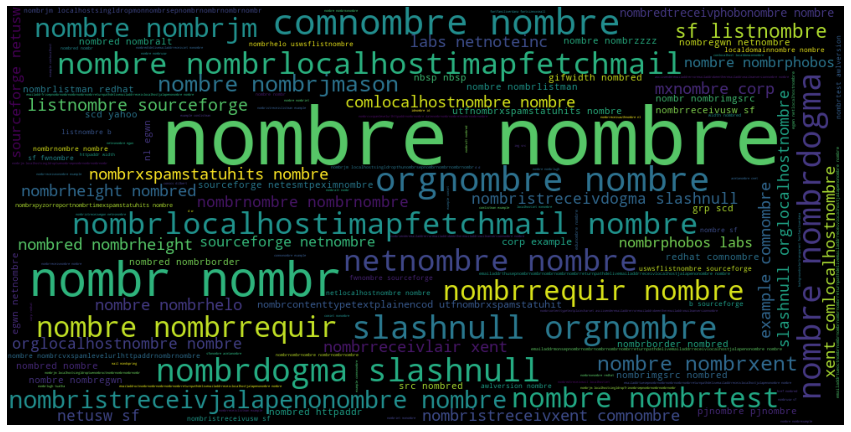

In [11]:
plot_WordCloud(ham_cleaned)

In [14]:
len(ham_cleaned)

2801

# VECTORIZATION

In [14]:
def vocabulary(emails,k=5):
    
    """
    emails : list of emails, each email is represented by a list of words
    
    k : a threshold, we  keep words that has a count > k
    
    """
    # all words in one list
    words_list = [word for email in emails for word in email]
    
    #a dictionnary where each word represent the key and the value is the word's count
    words_count_dict = dict(sorted(list(Counter(words_list).items()),key = lambda x :x[1] , reverse=True))
    
    #We keep words that has a count > k
    filtered_word_dict = dict(filter(lambda item: item[1] > k, words_count_dict.items()))
    
    #indexed words dictionnary
    word_to_index = { w : i for i,w in enumerate(filtered_word_dict.keys())}   
    
    return word_to_index
    

In [16]:
#indexed_vocabulary = vocabulary(ham_cleaned+spam_cleaned,10)
indexed_vocabulary = vocabulary(spam_cleaned,5)
len(indexed_vocabulary)

5069

In [17]:
def vectorization_bin(list_of_mails , vocab):
    
    """
    list_of_mails : list of emails , each email is represented with a list of its words
    
    vocab : a dictionnary where the key is a word and the value is a unique index
    
    """
  
    list_of_vects =[]
    
    for mail in list_of_mails:
        
        vect = [0]*len(vocab)
        
        for word in mail:
            
            if vocab.get(word,0):
                
                vect[vocab[word]]=1
                
        list_of_vects.append(vect)
        
    return np.array(list_of_vects)



In [18]:
def vectorization_comptage(list_of_mails , vocab):
    
    
    """
    list_of_mails : list of emails , each email is represented with a list of its words
    
    vocab : a dictionnary where the key is a word and the value is a unique index
    
    """
    list_of_vects =[]
    
    for mail in list_of_mails:
        
        vect = [0]*len(vocab)
        
        for word in mail:
            
            if vocab.get(word,0):
                vect[vocab[word]]+=1
                
        list_of_vects.append(vect)
        
    return np.array(list_of_vects)

In [19]:
ham_vectorized_bin = vectorization_bin(ham_cleaned , indexed_vocabulary)
spam_vectorized_bin = vectorization_bin(spam_cleaned , indexed_vocabulary)

In [20]:
print(ham_vectorized_bin.shape)
print(spam_vectorized_bin.shape)

(2801, 5069)
(1397, 5069)


# Splitting dataset

**1** pour spam et **0** pour ham

In [21]:
X = np.append(ham_vectorized_bin,spam_vectorized_bin,axis=0)

y = ham_vectorized_bin.shape[0]*[0] + spam_vectorized_bin.shape[0]*[1]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=1, 
                                                    test_size=0.3)

# MODEL BUILDING

In [22]:
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1200)

In [23]:
y_pred_rfc = rfc.predict(X_test)

print(f"accuracy score = {accuracy_score(y_test, y_pred_rfc)}")
print(f"f1 score = {f1_score(y_test, y_pred_rfc)}")

accuracy score = 0.9912698412698413
f1 score = 0.9869203329369798


In [24]:

clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_dt = clf.predict(X_test)

In [25]:

print(f"accuracy score = {accuracy_score(y_test, y_pred_dt)}")
print(f"f1 score = {f1_score(y_test, y_pred_dt)}")

accuracy score = 0.9841269841269841
f1 score = 0.9760191846522782


In [26]:
clf = SVC(kernel='linear')  # Linear kernel
clf.fit(X_train, y_train)



SVC(kernel='linear')

In [28]:
# Make predictions on the test data
y_pred_svm = clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)

Accuracy: 0.9952380952380953


In [29]:
clf = LogisticRegression()
clf.fit(X_train, y_train)


LogisticRegression()

In [30]:
y_pred_lr = clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

Accuracy: 0.9936507936507937


In [31]:
clf = KNeighborsClassifier(n_neighbors=5)  # Use 5 nearest neighbors
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
y_pred_knn = clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)

Accuracy: 0.9825396825396825


In [33]:
# Create an XGBoost classifier
xgb_clf = XGBClassifier(random_state=45)

# Train the classifier on the training set
xgb_clf.fit(X_train, y_train)

[23:24:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=45,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.9976190476190476


# NN

In [35]:
# Create the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:

# Train the model
model.fit(np.array(X_train, dtype=int), np.array(y_train, dtype=int), epochs=10, batch_size=32)


Epoch 1/10
92/92 [==============================] - 2s 12ms/step - loss: 0.1940 - accuracy: 0.9224
Epoch 2/10
92/92 [==============================] - 1s 12ms/step - loss: 0.0232 - accuracy: 0.9932
Epoch 3/10
92/92 [==============================] - 1s 10ms/step - loss: 0.0182 - accuracy: 0.9963
Epoch 4/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0041 - accuracy: 0.9993
Epoch 5/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0035 - accuracy: 0.9993
Epoch 6/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0027 - accuracy: 0.9986
Epoch 7/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 8/10
92/92 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 9/10
92/92 [==============================] - 1s 6ms/step - loss: 6.5938e-04 - accuracy: 1.0000
Epoch 10/10
92/92 [==============================] - 1s 6ms/step - loss: 5.3620e-04 - accuracy: 1.0000


In [37]:

# Evaluate the model on the test set
scores = model.evaluate(np.array(X_test, dtype=int), np.array(y_test, dtype=int), verbose=1)
#y_pred_nn = model.predict(X_test)

#y_pred_nn = np.argmax(y_pred_nn, axis=1)
#accuracy = accuracy_score(y_test, y_pred_nn)
#print("Accuracy:", accuracy)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

40/40 [==============================] - 0s 3ms/step - loss: 0.0322 - accuracy: 0.9921
Test loss: 0.03224810212850571
Test accuracy: 0.9920634627342224


In [ ]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['green', 'red']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam), palette=colors)
plt.show()

In [ ]:
def plot_WordCloud(text_list):
    unique_string=(" ").join(text_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [60]:
plot_WordCloud(text_easy_ham)

TypeError: sequence item 0: expected str instance, list found

In [ ]:
plot_WordCloud(text_hard_ham)

In [ ]:
plot_WordCloud(text_spam)

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)

In [ ]:
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [ ]:
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [ ]:
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)

In [ ]:
predictions = rfc.predict(X_test)

# Model Evaluation

# bars

In [ ]:
# Data for the algorithms
algorithms = ['Algorithm 1', 'Algorithm 2', 'Algorithm 3', 'Algorithm 4', 'Algorithm 5']
precision = [0.85, 0.78, 0.92, 0.81, 0.88]
recall = [0.92, 0.81, 0.89, 0.78, 0.86]
f1_score = [0.88, 0.79, 0.91, 0.79, 0.87]

# Set the width of each bar
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = range(len(algorithms))
r2 = [x + bar_width for x in r1]
r3 = [x + 2*bar_width for x in r1]

# Create the bar chart
plt.bar(r1, precision, color='b', width=bar_width, label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, label='F1-score')

# Set the x-axis labels and title
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Comparison of Algorithms - Precision, Recall, and F1-score')

# Set the x-axis tick positions and labels
plt.xticks([r + bar_width for r in range(len(algorithms))], algorithms)

# Add a legend
plt.legend()

# Show the bar chart
plt.show()

# roc

In [ ]:

# Data for the algorithms
algorithm1_predictions = [...]  # predicted probabilities for algorithm 1
algorithm2_predictions = [...]  # predicted probabilities for algorithm 2
algorithm3_predictions = [...]  # predicted probabilities for algorithm 3
algorithm4_predictions = [...]  # predicted probabilities for algorithm 4
algorithm5_predictions = [...]  # predicted probabilities for algorithm 5

# True labels for the data
true_labels = [...]  # true labels for the data

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Area Under the ROC curve (AUC) for each algorithm
fpr_algorithm1, tpr_algorithm1, _ = roc_curve(true_labels, algorithm1_predictions)
fpr_algorithm2, tpr_algorithm2, _ = roc_curve(true_labels, algorithm2_predictions)
fpr_algorithm3, tpr_algorithm3, _ = roc_curve(true_labels, algorithm3_predictions)
fpr_algorithm4, tpr_algorithm4, _ = roc_curve(true_labels, algorithm4_predictions)
fpr_algorithm5, tpr_algorithm5, _ = roc_curve(true_labels, algorithm5_predictions)

# Calculate AUC for each algorithm
auc_algorithm1 = auc(fpr_algorithm1, tpr_algorithm1)
auc_algorithm2 = auc(fpr_algorithm2, tpr_algorithm2)
auc_algorithm3 = auc(fpr_algorithm3, tpr_algorithm3)
auc_algorithm4 = auc(fpr_algorithm4, tpr_algorithm4)
auc_algorithm5 = auc(fpr_algorithm5, tpr_algorithm5)

# Plot the combined ROC curve
plt.plot(fpr_algorithm1, tpr_algorithm1, label='Algorithm 1 (AUC = {:.2f})'.format(auc_algorithm1))
plt.plot(fpr_algorithm2, tpr_algorithm2, label='Algorithm 2 (AUC = {:.2f})'.format(auc_algorithm2))
plt.plot(fpr_algorithm3, tpr_algorithm3, label='Algorithm 3 (AUC = {:.2f})'.format(auc_algorithm3))
plt.plot(fpr_algorithm4, tpr_algorithm4, label='Algorithm 4 (AUC = {:.2f})'.format(auc_algorithm4))
plt.plot(fpr_algorithm5, tpr_algorithm5, label='Algorithm 5 (AUC = {:.2f})'.format(auc_algorithm5))

# Set x-axis and y-axis labels
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Comparison of Algorithms')
plt.legend(loc='lower right')  # Add a legend in the lower right corner

# Show the ROC curve
plt.show()

In [ ]:
print("accuracy score = {}%".format(round(accuracy_score(y_test, predictions)*100, 2)))
print("f1 score = {}".format(round(f1_score(y_test, predictions), 2)))

In [ ]:
conf_mx = confusion_matrix(y_test, predictions)

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

In [ ]:
y_scores = cross_val_predict(rfc, X = X_train, y = y_train.reshape((1, len(y_train)))[0], cv=5, 
                             method="predict_proba")

In [ ]:
 precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

In [ ]:
plt.figure(figsize=(10,4), dpi=200)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16) # Not shown in the book
plt.xlabel("Threshold", fontsize=16)        # Not shown
plt.grid(True) 
plt.title("precision recall curve")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:,1])
roc_auc_score(y_train, y_scores[:,1])

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, color='r')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.grid(True)
plt.title("ROC Curve")
plt.show()

# Data Pipeline

In [ ]:
my_pipeline = Pipeline(steps=[
    ('text', email_to_clean_text()),
    ('vector', vectorizer),
    ('model', rfc)])

In [ ]:
y1 = np.array(len(ham)*[0]+len(spam)*[1]).reshape(len(ham+spam), 1)

In [ ]:
y1

In [ ]:
my_pipeline.fit(ham+spam, y1)


**ham : 0**

**spam : 1**

In [ ]:
my_pipeline.predict([hard_ham[77]])